# 🎯 TEDx Talks Recommendation System

## TEDx talks have inspired millions of people worldwide with stories, ideas, and insights across diverse topics — from science and technology to art and personal growth.  
## With thousands of talks available, finding the right one can be overwhelming.

## **Goal:**  
## Build a recommendation system that suggests TEDx talks similar to a user’s interests using content-based filtering.


## **Why this matters:**  
## A good recommender can help learners, professionals, and curious minds discover talks they might never have found otherwise.

## **Dataset:**  
## TED Talks dataset from [Kaggle](https://www.kaggle.com/datasets/rounakbanik/ted-talks) containing metadata like titles, speakers, tags, and transcripts.

In [3]:
# Import Required Libraries

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Recommendation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Text preprocessing
import nltk
from nltk.corpus import stopwords
import string

# Download NLTK stopwords if not already present
nltk.download('stopwords')

# Set visual style
sns.set(style="whitegrid", palette="muted")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 3 — Load and Preview the Data

## We’ll load the TEDx dataset into a Pandas DataFrame,  
## preview the first few rows, and check for missing values to ensure data quality.

In [4]:
# Load Dataset

# Path to the dataset (place tedx_dataset.csv in the same folder as this notebook)
data_path = "tedx_dataset.csv.csv"

# Read the CSV file
df = pd.read_csv(data_path)

# Quick overview
print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
display(df.head(3))  # Show first 3 rows

# Check for missing values
missing_counts = df.isnull().sum()
if missing_counts.any():
    print("\nMissing Values Found:")
    print(missing_counts[missing_counts > 0])
else:
    print("\nNo missing values detected 🎯")


Dataset Shape: 2550 rows × 17 columns


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292



Missing Values Found:
speaker_occupation    6
dtype: int64


## Step 4 — Exploratory Data Analysis (EDA)

## Before building the recommendation engine,  
## let’s understand our dataset:  
## - How many talks are there?  
## - Who are the top speakers?  
## - Which tags are most common?  
## - What’s the distribution of views?  

## This helps us spot patterns and clean the data more effectively.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   comments            2550 non-null   int64 
 1   description         2550 non-null   object
 2   duration            2550 non-null   int64 
 3   event               2550 non-null   object
 4   film_date           2550 non-null   int64 
 5   languages           2550 non-null   int64 
 6   main_speaker        2550 non-null   object
 7   name                2550 non-null   object
 8   num_speaker         2550 non-null   int64 
 9   published_date      2550 non-null   int64 
 10  ratings             2550 non-null   object
 11  related_talks       2550 non-null   object
 12  speaker_occupation  2544 non-null   object
 13  tags                2550 non-null   object
 14  title               2550 non-null   object
 15  url                 2550 non-null   object
 16  views               2550

,comments,duration,film_date,languages,num_speaker,published_date,views
count,2550.000000,2550.000000,2.550000e+03,2550.000000,2550.000000,2.550000e+03,2.550000e+03
mean,191.562353,826.510196,1.321928e+09,27.326275,1.028235,1.343525e+09,1.698297e+06
std,282.315223,374.009138,1.197391e+08,9.563452,0.207705,9.464009e+07,2.498479e+06
min,2.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,5.044300e+04
25%,63.000000,577.000000,1.257466e+09,23.000000,1.000000,1.268463e+09,7.557928e+05
50%,118.000000,848.000000,1.333238e+09,28.000000,1.000000,1.340935e+09,1.124524e+06
75%,221.750000,1046.750000,1.412964e+09,33.000000,1.000000,1.423432e+09,1.700760e+06
max,6404.000000,5256.000000,1.503792e+09,72.000000,5.000000,1.506092e+09,4.722711e+07


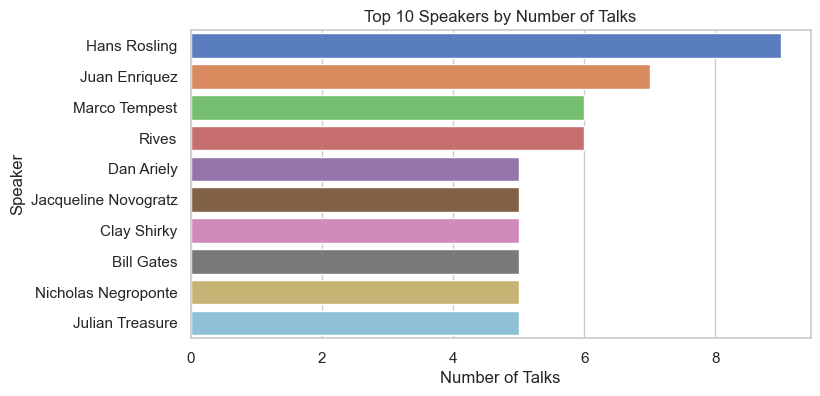

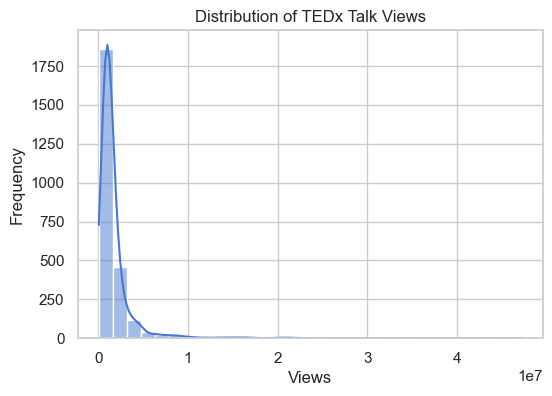

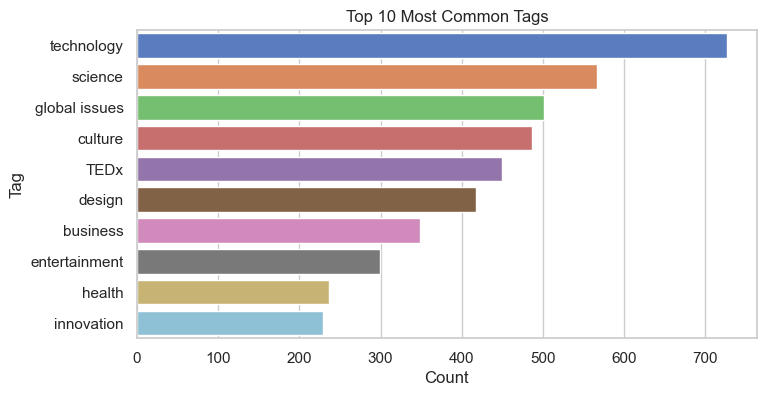

In [7]:
# Step 4 — Exploratory Data Analysis (Auto-detect version)

# 1. Basic dataset info
df.info()

# 2. Summary statistics for numeric columns
display(df.describe())

# 3. Top 10 speakers by number of talks (auto-detect column)
speaker_col = None
if 'speaker' in df.columns:
    speaker_col = 'speaker'
elif 'main_speaker' in df.columns:
    speaker_col = 'main_speaker'

if speaker_col:
    top_speakers = df[speaker_col].value_counts().head(10)
    plt.figure(figsize=(8,4))
    sns.barplot(x=top_speakers.values, y=top_speakers.index)
    plt.title("Top 10 Speakers by Number of Talks")
    plt.xlabel("Number of Talks")
    plt.ylabel("Speaker")
    plt.show()
else:
    print("No speaker column found in dataset.")

# 4. Distribution of views
plt.figure(figsize=(6,4))
sns.histplot(df['views'], bins=30, kde=True)
plt.title("Distribution of TEDx Talk Views")
plt.xlabel("Views")
plt.ylabel("Frequency")
plt.show()

# 5. Most common tags
if 'tags' in df.columns:
    from collections import Counter
    all_tags = []
    for tag_list in df['tags'].dropna():
        all_tags.extend(tag_list.strip("[]").replace("'", "").split(", "))
    tag_counts = Counter(all_tags).most_common(10)
    
    tags_df = pd.DataFrame(tag_counts, columns=['Tag', 'Count'])
    plt.figure(figsize=(8,4))
    sns.barplot(x='Count', y='Tag', data=tags_df)
    plt.title("Top 10 Most Common Tags")
    plt.show()





## Step 5 — Data Cleaning & Preprocessing

## For a content-based recommender, clean text is essential.  
## We will:
## 1. Remove missing values in important columns.
## 2. Normalize text (lowercase, remove punctuation, stopwords).
## 3. Create a single "combined_text" column that merges title, description, and tags for each talk.


In [8]:
# Data Cleaning & Preprocessing

# 1. Keep only rows where essential fields are present
essential_cols = ['title', 'description', 'tags']
df = df.dropna(subset=essential_cols)

# 2. Prepare stopwords and punctuation list
stop_words = set(stopwords.words('english'))
punctuations = string.punctuation

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([ch for ch in text if ch not in punctuations])
    # Remove stopwords
    words = [word for word in text.split() if word not in stop_words]
    return ' '.join(words)

# 3. Apply cleaning to title, description, and tags
df['title_clean'] = df['title'].apply(clean_text)
df['description_clean'] = df['description'].apply(clean_text)

# Convert tags list/string into clean text
def clean_tags(tag_str):
    if isinstance(tag_str, str):
        tag_str = tag_str.strip("[]").replace("'", "").replace('"', '')
        return clean_text(tag_str)
    return ""

df['tags_clean'] = df['tags'].apply(clean_tags)

# 4. Create combined text for recommendation
df['combined_text'] = (
    df['title_clean'] + " " +
    df['description_clean'] + " " +
    df['tags_clean']
)

print(" Text cleaning complete. Sample:")
display(df[['title', 'combined_text']].head(3))


 Text cleaning complete. Sample:


,title,combined_text
0,Do schools kill creativity?,schools kill creativity sir ken robinson makes...
1,Averting the climate crisis,averting climate crisis humor humanity exuded ...
2,Simplicity sells,simplicity sells new york times columnist davi...


## Step 6 — Feature Engineering & Similarity Calculation

## We will:
## 1. Convert the cleaned "combined_text" into TF-IDF vectors.
## 2. Measure similarity between talks using cosine similarity.
## 3. Store the similarity matrix for quick recommendations.


In [9]:
# Step 6 — Feature Engineering & Similarity Calculation

# 1. Create TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # limit features for speed
tfidf_matrix = tfidf.fit_transform(df['combined_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")

# 2. Compute cosine similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

print("Similarity matrix created.")


TF-IDF matrix shape: (2550, 5000)
Similarity matrix created.


## Step 7 — Building the Recommendation Function

## We will:
## 1. Take a talk title as input.
## 2. Find its index in the dataset.
## 3. Sort all talks by similarity score.
## 4. Return the top N recommended talks.


In [10]:
# Recommendation Function

def recommend_talks(title, top_n=5):
    """
    Recommend TEDx talks similar to the given title.

    Parameters:
    ----------
    title : str
        Title of the TEDx talk to base recommendations on.
    top_n : int
        Number of recommendations to return.

    Returns:
    -------
    list
        List of recommended talk titles.
    """
    if title not in df['title'].values:
        print(f"❌ '{title}' not found in dataset.")
        return []
    
    # Get the index of the talk
    idx = df[df['title'] == title].index[0]
    
    # Get similarity scores for this talk
    scores = list(enumerate(similarity_matrix[idx]))
    
    # Sort by similarity (highest first), skip the first (it's the same talk)
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    
    # Fetch titles of recommended talks
    recommended_titles = [df.iloc[i[0]]['title'] for i in scores]
    
    print(f"\n🎯 Recommendations for: {title}\n")
    for i, rec_title in enumerate(recommended_titles, 1):
        print(f"{i}. {rec_title}")
    
    return recommended_titles

# Example:
recommend_talks("The future we're building -- and boring")



🎯 Recommendations for: The future we're building -- and boring

1. The mind behind Tesla, SpaceX, SolarCity ...
2. A 40-year plan for energy
3. The story behind the Mars Rovers
4. Energy from floating algae pods
5. Your kids might live on Mars. Here's how they'll survive


['The mind behind Tesla, SpaceX, SolarCity ...',
 'A 40-year plan for energy',
 'The story behind the Mars Rovers',
 'Energy from floating algae pods',
 "Your kids might live on Mars. Here's how they'll survive"]

## Step 8 — Interactive Search with User Input

## We will:
## 1. Prompt the user to enter a TEDx talk title.
## 2. Search for recommendations live.
## 3. Repeat until the user types "exit".


In [ ]:
# Interactive Search

while True:
    user_title = input("\nEnter a TEDx talk title (or type 'exit' to quit): ").strip()
    
    if user_title.lower() == "exit":
        print("👋 Exiting TEDx Recommendation System.")
        break
    
    recommend_talks(user_title, top_n=5)



Enter a TEDx talk title (or type 'exit' to quit): do schools kill creativity
❌ 'do schools kill creativity' not found in dataset.

Enter a TEDx talk title (or type 'exit' to quit): A 40-year plan for energy

🎯 Recommendations for: A 40-year plan for energy

1. Let's transform energy -- with natural gas
2. High-altitude wind energy from kites!
3. Energy from floating algae pods
4. The missing link to renewable energy
5. Plant fuels that could power a jet
